C:\Users\kumar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


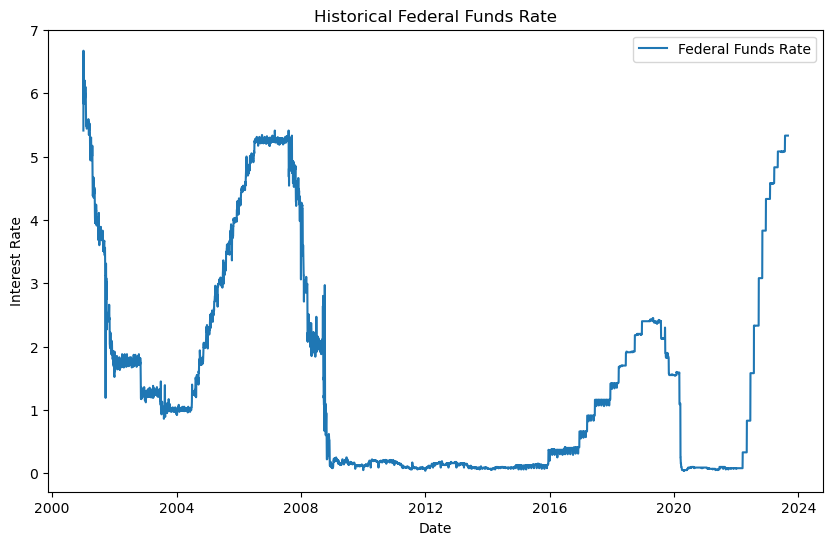

Optimized parameters: a=0.1, b=1.0, sigma=0.5


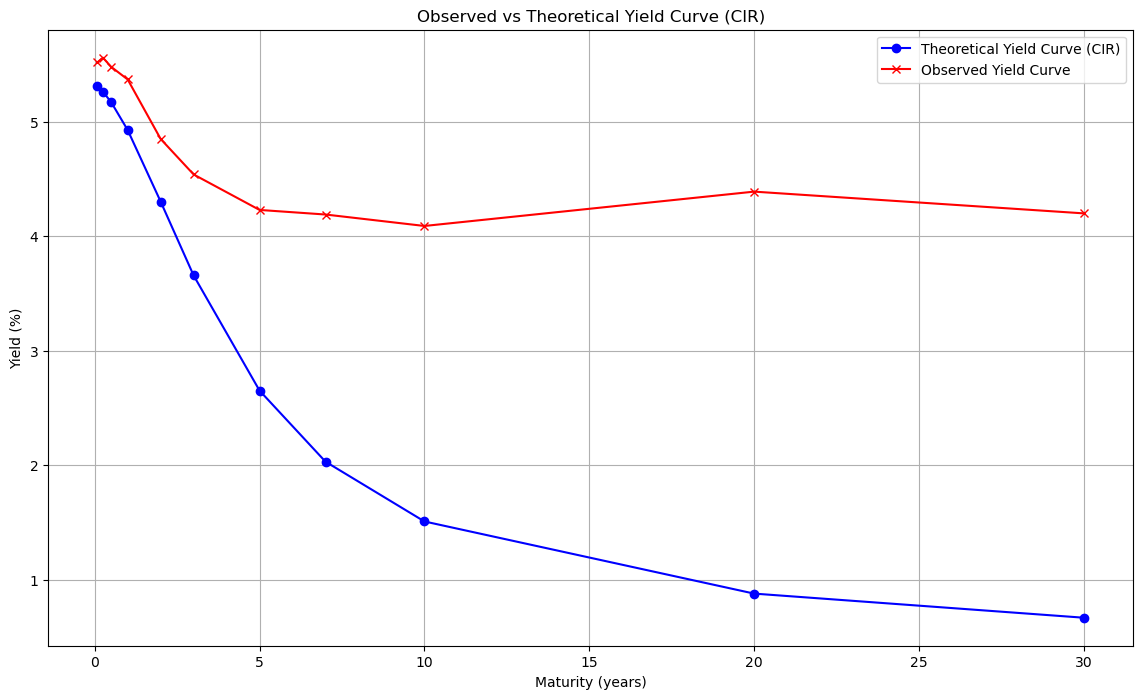

In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d


start_date = '2001-01-01'
end_date = '2023-08-31'
data = web.DataReader('DFF', 'fred', start_date, end_date)


interest_rates = data.rename(columns={'DFF': 'Rate'})


interest_rates.to_csv("federal_funds_rates.csv")

plt.figure(figsize=(10, 6))
plt.plot(interest_rates, label='Federal Funds Rate')
plt.title('Historical Federal Funds Rate')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()


interest_rates = interest_rates.dropna()
delta_rates = interest_rates.diff().dropna()


def cir_log_likelihood(params, rates, delta_rates):
    a, b, sigma = params
    dt = 1 / 252
    r = rates[:-1]
    dr = delta_rates
    variance = sigma**2 * r * dt
    mean = a * (b - r) * dt
    log_likelihood = -np.sum(np.log(variance) + (dr - mean) ** 2 / variance)
    return -log_likelihood


initial_params = [0.1, interest_rates['Rate'].mean(), interest_rates['Rate'].std()]


bounds = [(0.0001, 1.0), (0.0001, 1.0), (0.0001, 0.5)]


result = minimize(cir_log_likelihood, initial_params, args=(interest_rates['Rate'].values, delta_rates['Rate'].values), method='SLSQP', bounds=bounds)


a_cir, b_cir, sigma_cir = result.x
print(f"Optimized parameters: a={a_cir}, b={b_cir}, sigma={sigma_cir}")


def cir_yield_curve(a, b, sigma, r0, maturities):
    yields = []
    for T in maturities:
        h = np.sqrt(a**2 + 2 * sigma**2)
        A = ((2 * h * np.exp((a + h) * T / 2)) / ((2 * h + (a + h) * (np.exp(h * T) - 1))))**(2 * a * b / sigma**2)
        B = (2 * (np.exp(h * T) - 1)) / (2 * h + (a + h) * (np.exp(h * T) - 1))
        yield_rate = (-np.log(A) + B * r0) / T
        yields.append(yield_rate)
    return np.array(yields)

maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])


theoretical_yields_cir = cir_yield_curve(a_cir, b_cir, sigma_cir, interest_rates['Rate'].iloc[-1], maturities)


yield_data = web.DataReader(['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'], 'fred', '2023-08-31', '2023-08-31')


observed_yields = yield_data.iloc[0].values

plt.figure(figsize=(14, 8))
plt.plot(maturities, theoretical_yields_cir, label="Theoretical Yield Curve (CIR)", marker='o', linestyle='-', color='blue')
plt.plot(maturities, observed_yields, label="Observed Yield Curve", marker='x', linestyle='-', color='red')
plt.title("Observed vs Theoretical Yield Curve (CIR)")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()


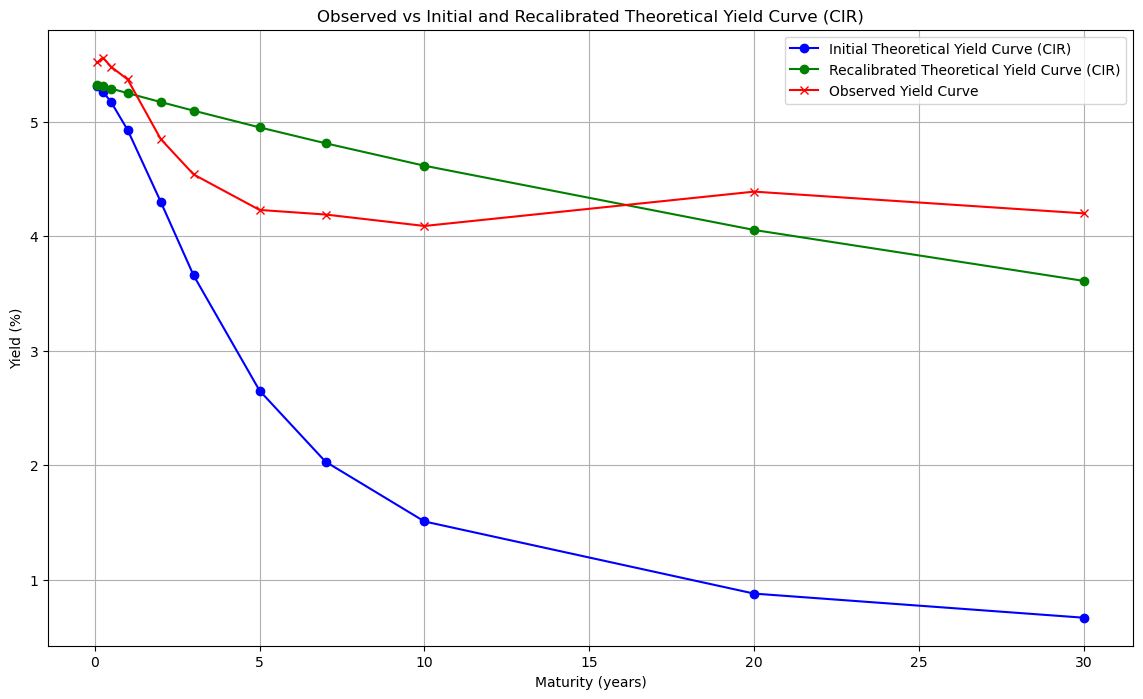

Recalibrated parameters: a=0.037167294097067566, b=1.0, sigma=0.00012664340370667065


In [3]:

def sse_cir(params, observed_yields, maturities, r0):
    a, b, sigma = params
    theoretical_yields = cir_yield_curve(a, b, sigma, r0, maturities)
    sse = np.sum((observed_yields - theoretical_yields) ** 2)
    return sse


def recalibrate_cir(observed_yields, maturities, r0):
    initial_params = [0.1, 0.1, 0.1]
    bounds = [(0.0001, 1.0), (0.0001, 1.0), (0.0001, 0.5)]
    result = minimize(sse_cir, initial_params, args=(observed_yields, maturities, r0), method='SLSQP', bounds=bounds)
    a, b, sigma = result.x
    return a, b, sigma

r0 = interest_rates['Rate'].iloc[-1]


a_recalibrated_cir, b_recalibrated_cir, sigma_recalibrated_cir = recalibrate_cir(observed_yields, maturities, r0)


theoretical_yields_recalibrated_cir = cir_yield_curve(a_recalibrated_cir, b_recalibrated_cir, sigma_recalibrated_cir, r0, maturities)


plt.figure(figsize=(14, 8))
plt.plot(maturities, theoretical_yields_cir, label="Initial Theoretical Yield Curve (CIR)", marker='o', linestyle='-', color='blue')
plt.plot(maturities, theoretical_yields_recalibrated_cir, label="Recalibrated Theoretical Yield Curve (CIR)", marker='o', linestyle='-', color='green')
plt.plot(maturities, observed_yields, label="Observed Yield Curve", marker='x', linestyle='-', color='red')
plt.title("Observed vs Initial and Recalibrated Theoretical Yield Curve (CIR)")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()


print(f"Recalibrated parameters: a={a_recalibrated_cir}, b={b_recalibrated_cir}, sigma={sigma_recalibrated_cir}")


In [4]:
def calculate_forward_rates(yields, maturities):
    forward_rates = []
    for i in range(len(maturities) - 1):
        t1 = maturities[i]
        t2 = maturities[i + 1]
        y1 = yields[i]
        y2 = yields[i + 1]
        forward_rate = ((t2 * y2) - (t1 * y1)) / (t2 - t1)
        forward_rates.append(forward_rate)
    return np.array(forward_rates)


forward_rates_theoretical_cir = calculate_forward_rates(theoretical_yields_cir, maturities)
forward_rates_recalibrated_cir = calculate_forward_rates(theoretical_yields_recalibrated_cir, maturities)
forward_rates_observed = calculate_forward_rates(observed_yields, maturities)


forward_maturities = maturities[:-1] + np.diff(maturities) / 2


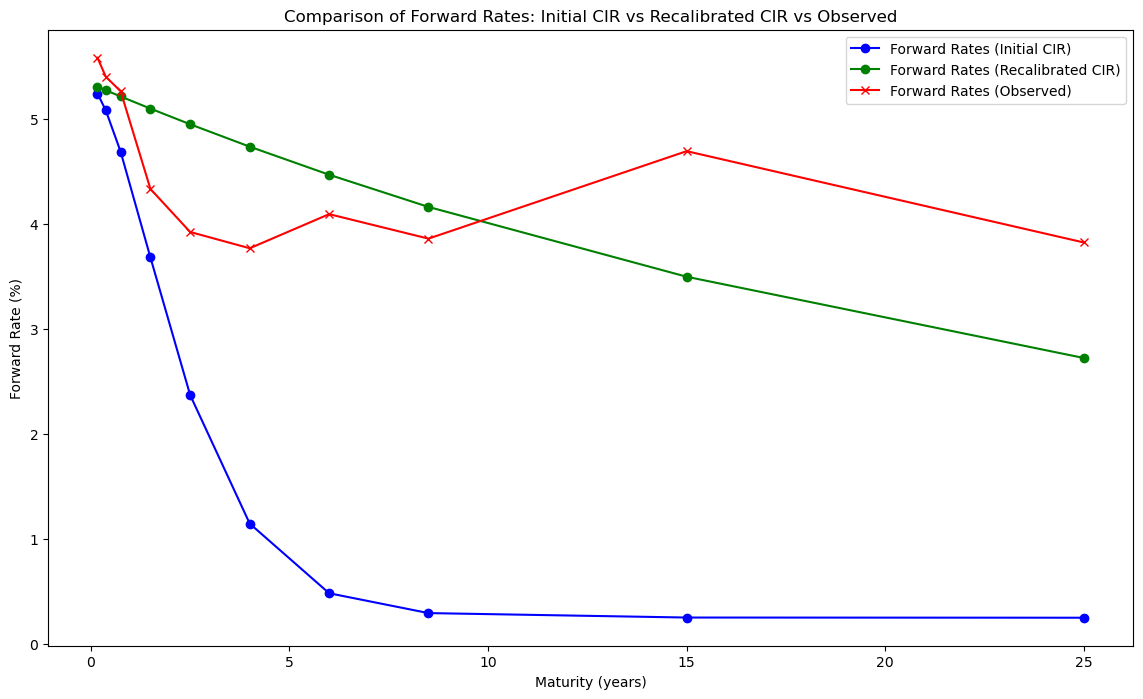

In [5]:

plt.figure(figsize=(14, 8))
plt.plot(forward_maturities, forward_rates_theoretical_cir, label="Forward Rates (Initial CIR)", marker='o', linestyle='-', color='blue')
plt.plot(forward_maturities, forward_rates_recalibrated_cir, label="Forward Rates (Recalibrated CIR)", marker='o', linestyle='-', color='green')
plt.plot(forward_maturities, forward_rates_observed, label="Forward Rates (Observed)", marker='x', linestyle='-', color='red')
plt.title("Comparison of Forward Rates: Initial CIR vs Recalibrated CIR vs Observed")
plt.xlabel("Maturity (years)")
plt.ylabel("Forward Rate (%)")
plt.legend()


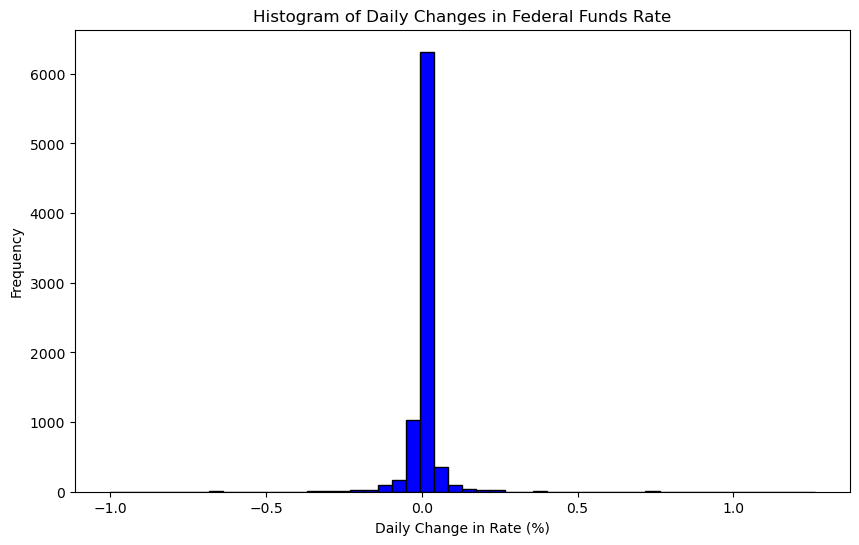

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(delta_rates, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Daily Changes in Federal Funds Rate')
plt.xlabel('Daily Change in Rate (%)')
plt.ylabel('Frequency')
plt.show()


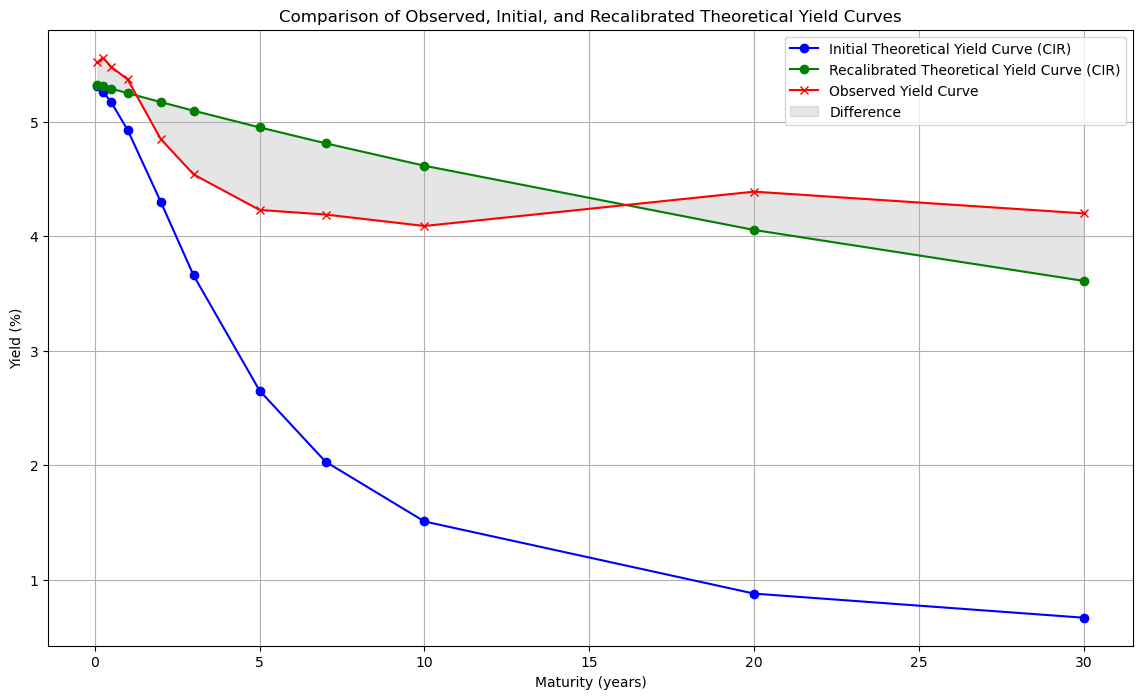

In [7]:
plt.figure(figsize=(14, 8))
plt.plot(maturities, theoretical_yields_cir, label="Initial Theoretical Yield Curve (CIR)", marker='o', linestyle='-', color='blue')
plt.plot(maturities, theoretical_yields_recalibrated_cir, label="Recalibrated Theoretical Yield Curve (CIR)", marker='o', linestyle='-', color='green')
plt.plot(maturities, observed_yields, label="Observed Yield Curve", marker='x', linestyle='-', color='red')
plt.fill_between(maturities, theoretical_yields_recalibrated_cir, observed_yields, color='gray', alpha=0.2, label="Difference")
plt.title("Comparison of Observed, Initial, and Recalibrated Theoretical Yield Curves")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()


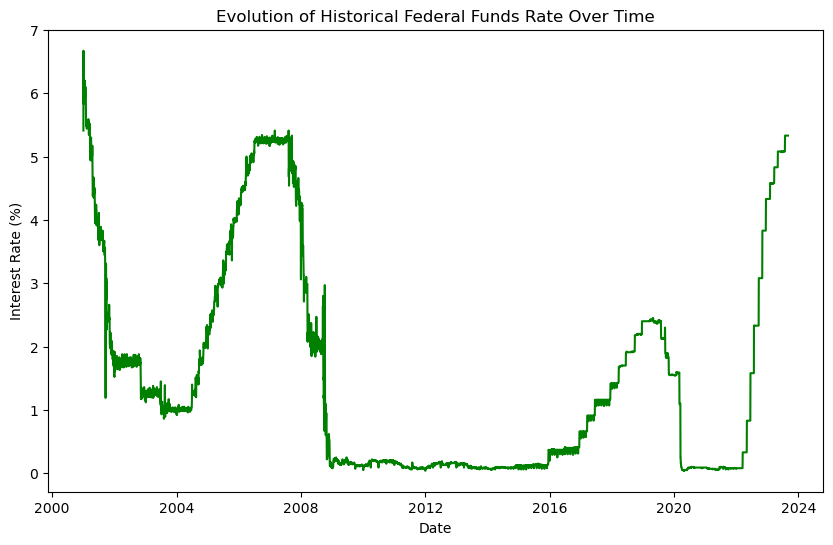

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(interest_rates, color='green')
plt.title('Evolution of Historical Federal Funds Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate (%)')
plt.show()


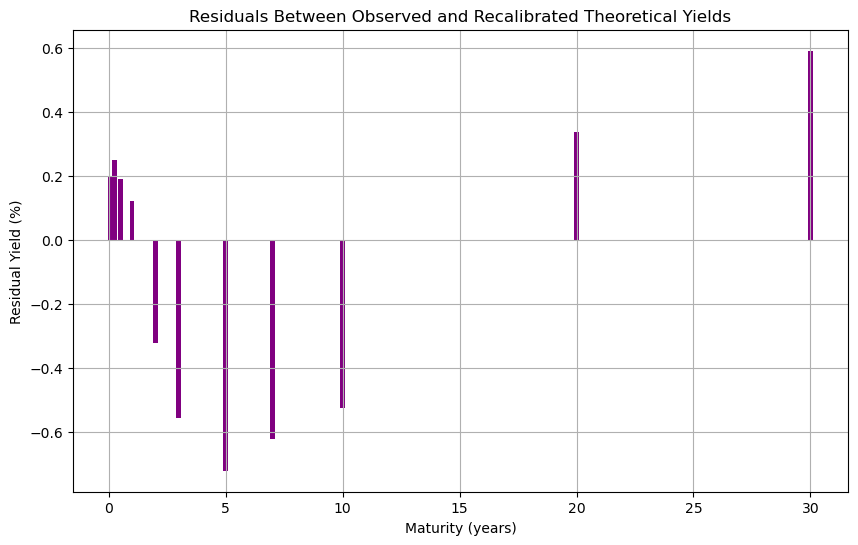

In [9]:
residuals = observed_yields - theoretical_yields_recalibrated_cir

plt.figure(figsize=(10, 6))
plt.bar(maturities, residuals, width=0.2, color='purple')
plt.title('Residuals Between Observed and Recalibrated Theoretical Yields')
plt.xlabel('Maturity (years)')
plt.ylabel('Residual Yield (%)')
plt.grid(True)
plt.show()


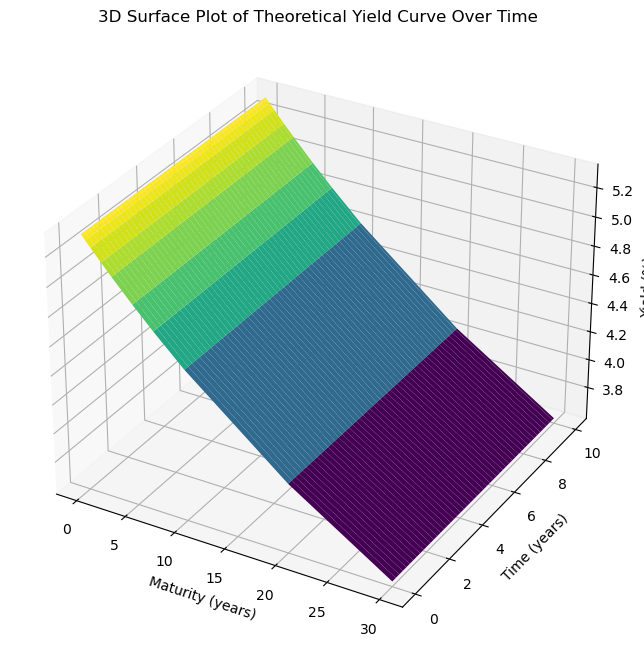

In [11]:
from mpl_toolkits.mplot3d import Axes3D


time_periods = np.linspace(0, 10, 100)  
theoretical_yields_surface = np.array([cir_yield_curve(a_recalibrated_cir, b_recalibrated_cir, sigma_recalibrated_cir, r0, maturities) for t in time_periods])

X, Y = np.meshgrid(maturities, time_periods)
Z = theoretical_yields_surface

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_title('3D Surface Plot of Theoretical Yield Curve Over Time')
ax.set_xlabel('Maturity (years)')
ax.set_ylabel('Time (years)')
ax.set_zlabel('Yield (%)')
plt.show()
